In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import xgboost as xgb

In [62]:
# Get data

CLEAN_DATA_FILEPATH = "../data/clean/clean-stroke-data.csv"

clean_df = pd.read_csv(CLEAN_DATA_FILEPATH)
clean_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [63]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4908 entries, 0 to 4907
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4908 non-null   object 
 1   age                4908 non-null   float64
 2   hypertension       4908 non-null   int64  
 3   heart_disease      4908 non-null   int64  
 4   ever_married       4908 non-null   object 
 5   work_type          4908 non-null   object 
 6   Residence_type     4908 non-null   object 
 7   avg_glucose_level  4908 non-null   float64
 8   bmi                4908 non-null   float64
 9   smoking_status     4908 non-null   object 
 10  stroke             4908 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 421.9+ KB


In [64]:
# Define features and target

X = clean_df.drop(columns = ["stroke"])
y = clean_df["stroke"]

In [65]:
X_num = X.select_dtypes(exclude = ['object'])
X_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4908 entries, 0 to 4907
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                4908 non-null   float64
 1   hypertension       4908 non-null   int64  
 2   heart_disease      4908 non-null   int64  
 3   avg_glucose_level  4908 non-null   float64
 4   bmi                4908 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 191.8 KB


In [66]:
X_cat = X.select_dtypes(include=['object'])
X_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4908 entries, 0 to 4907
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          4908 non-null   object
 1   ever_married    4908 non-null   object
 2   work_type       4908 non-null   object
 3   Residence_type  4908 non-null   object
 4   smoking_status  4908 non-null   object
dtypes: object(5)
memory usage: 191.8+ KB


In [67]:
# Create pipeline

cat_features = X_cat.columns.to_list()

categorical_transformer = make_pipeline(
    OneHotEncoder(),
)

features_transformer = ColumnTransformer(
     transformers=[
        ("categorical", 
         categorical_transformer, 
         cat_features),
    ],
    remainder='passthrough'  # Keeps the rest of the columns

)

# Fit and transform the DataFrame
encoded_data = features_transformer.fit_transform(X)

In [68]:
encoded_data.shape

(4908, 20)

In [69]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)


model = make_pipeline(
                features_transformer,
                xgb.XGBClassifier(objective='binary:logistic', 
                                eval_metric='auc', 
                                verbosity=0))

# Train the models
model.fit(X_train, y_train)

# Make predictions for model_logloss
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model with the custom threshold
roc_auc= roc_auc_score(y_test, y_pred_proba)

print(f'ROC AUC (logloss): {roc_auc}')

ROC AUC (logloss): 0.7536727456940223


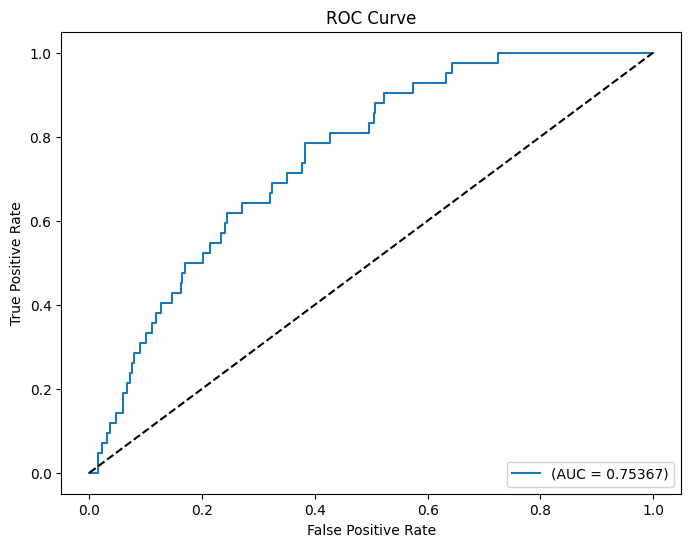

In [70]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'(AUC = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

ROC AUC (logloss): 0.7536727456940223
Precision (default threshold): 0.0
Recall (default threshold): 0.0
F1 Score (default threshold): 0.0
Accuracy (default threshold): 0.9480651731160896
Confusion Matrix (default threshold):
[[931   9]
 [ 42   0]]


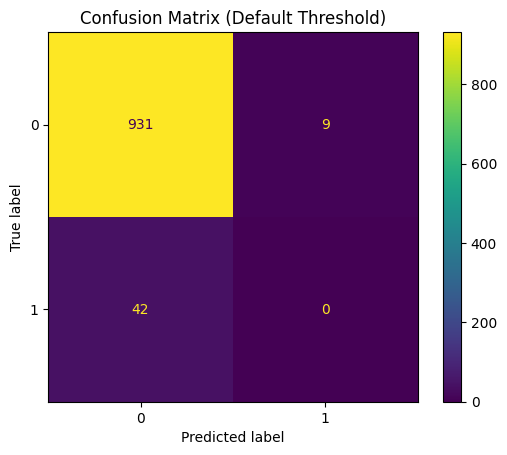

Best threshold: 0.003418071661144495
Precision (custom threshold): 0.08418367346938775
Recall (custom threshold): 0.7857142857142857
F1 Score (custom threshold): 0.15207373271889402
Accuracy (custom threshold): 0.6252545824847251
Confusion Matrix (custom threshold):
[[581 359]
 [  9  33]]


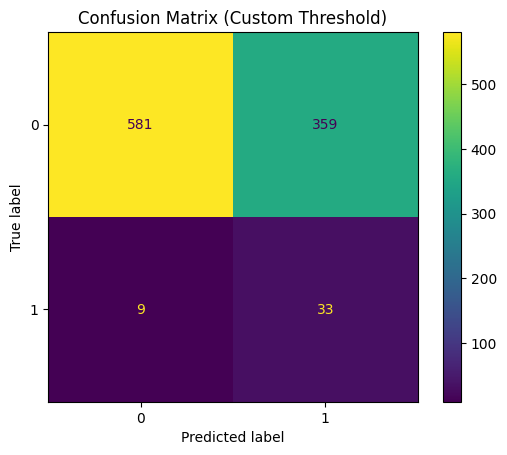

In [71]:
# Evaluation

# Evaluate the model with the default threshold (0.5)
y_pred_default_threshold = (y_pred_proba >= 0.5).astype(int)
roc_auc_logloss = roc_auc_score(y_test, y_pred_proba)
precision_default = precision_score(y_test, y_pred_default_threshold)
recall_default = recall_score(y_test, y_pred_default_threshold)
f1_default = f1_score(y_test, y_pred_default_threshold)
accuracy_default = accuracy_score(y_test, y_pred_default_threshold)

print(f'ROC AUC (logloss): {roc_auc_logloss}')
print(f'Precision (default threshold): {precision_default}')
print(f'Recall (default threshold): {recall_default}')
print(f'F1 Score (default threshold): {f1_default}')
print(f'Accuracy (default threshold): {accuracy_default}')

# Confusion Matrix for default threshold
conf_matrix_default = confusion_matrix(y_test, y_pred_default_threshold)
print(f'Confusion Matrix (default threshold):\n{conf_matrix_default}')
ConfusionMatrixDisplay(conf_matrix_default).plot()
plt.title('Confusion Matrix (Default Threshold)')
plt.show()

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Find the threshold that gives the best trade-off
optimal_idx = np.argmax(tpr - fpr)
best_threshold = thresholds[optimal_idx]

# Evaluate the model with the custom threshold
y_pred_custom_threshold = (y_pred_proba >= best_threshold).astype(int)
precision_custom = precision_score(y_test, y_pred_custom_threshold)
recall_custom = recall_score(y_test, y_pred_custom_threshold)
f1_custom = f1_score(y_test, y_pred_custom_threshold)
accuracy_custom = accuracy_score(y_test, y_pred_custom_threshold)

print(f'Best threshold: {best_threshold}')
print(f'Precision (custom threshold): {precision_custom}')
print(f'Recall (custom threshold): {recall_custom}')
print(f'F1 Score (custom threshold): {f1_custom}')
print(f'Accuracy (custom threshold): {accuracy_custom}')

# Confusion Matrix for custom threshold
conf_matrix_custom = confusion_matrix(y_test, y_pred_custom_threshold)
print(f'Confusion Matrix (custom threshold):\n{conf_matrix_custom}')
ConfusionMatrixDisplay(conf_matrix_custom).plot()
plt.title('Confusion Matrix (Custom Threshold)')
plt.show()
